# PDE-based Bayesian Problems using CUQIpy and CUQIpy-FEniCS plugin

Here we build a Bayesian inverse problem to infer the conductivity in a physical system modelled by the Poisson equation (applications include EIT problems).

The PDE model is built using FEniCS, then we use CUQIpy-FEniCS to wrap the PDE model to interface it with CUQIpy. We use CUQIpy samplers to solve the PDE-based Bayesian problem.

## Learning objectives of this notebook:
- Build a FEniCS based Poisson problem 
- Build and solve the PDE-based Bayesian problem in CUQIpy
	- Use Matern covariance operator for the prior
	- Use pCN sampler
- Use gradient-based sampler
	- The chain rule
	- Use NUTS sampler 

## Table of contents
1. [Building a FEniCS based Poisson problem](#PDEproblem)
2. [Building and solving the PDE-based Bayesian problem in CUQIpy](#Bayesian_problem)
3. [Using gradient-based sampler](#gradient_sampling)


## Import required libraries and set up configuration

In [153]:
from scipy import optimize
import ufl
import matplotlib.pyplot as plt
import sys
import cuqi
import cuqipy_fenics
import dolfin as dl
import numpy as np

## 1. Building a FEniCS based Poisson problem <a class="anchor" id="PDEproblem"></a>

In this section, we use FEniCS python library to build a PDE model. 

The PDE model we consider here is a 2D steady-state problem (Poisson):

\begin{align*}
 \nabla \cdot \left(\kappa(\mathbf{x}) \nabla u(\mathbf{x})\right) &= f(x) \;\;\;\;\mathrm{ in }\; (0,1)\times(0,1),\\
u(0,y)&=0 \;\;\;\;\mathrm{on}\; x=0\\
u(1,y)&=0 \;\;\;\;\mathrm{on}\; x=1 \\
\kappa(x)\nabla u(x,0)\cdot n&=0 \;\;\;\;\mathrm{on}\; y=0 \\
\kappa(x)\nabla u(x,1)\cdot n&=0 \;\;\;\;\mathrm{on}\; y=1 
\end{align*}



- where $\kappa(x)$ is the conductivity, $u(x)$ is the PDE solution (potential), $f(x)$ is the source term.

- We use the parameterization $\kappa(x) = e^{m(x)}$, to ensure positivity of the inferred conductivity (more on this later).

- We denote the discretized system that we need to solve as
$\mathbf{A}(\mathbf{m})\mathbf{U} = \mathbf{F}$
  - $\mathbf{A}$ is the discretized diffusion differential operator
  - $\mathbf{m}$ is the discretized Bayesian parameter 
  - $\mathbf{U}$ is the discretized solution (the potential)
  - $\mathbf{F}$ is the discretized RHS (the source term) 

### The discretization 

We use finite element discretization of the model above where the solution and the parameters are approximated in a second and first order Lagrange polynomial space, respectively. 

Using finite element formulation requires building the weak form of the PDE. To formulate the weak form, we multiply the PDE by a test function and integrate by parts and substitute the Neumann boundary conditions above (the last two equations above).

For formulating the weak form, see for example [this reference](https://en.wikiversity.org/wiki/Finite_elements/Weak_form_of_Poisson_equation).

### 1.1. Set up mesh

We create a 2D FEniCS mesh (unit square mesh) on which the finite element solution is discretized.

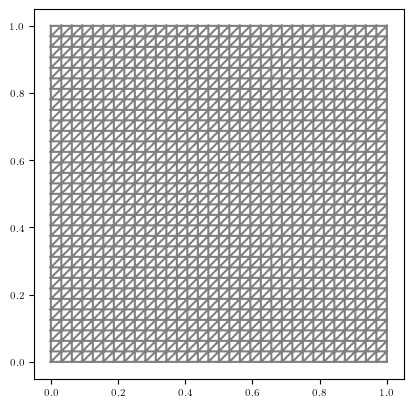

In [154]:
nx = 32 #12 # number of vertices on the x dimension
ny = 32 # number of vertices on the y dimension
mesh = dl.UnitSquareMesh(nx, ny) # create FEniCS mesh
dl.plot(mesh)

### 1.2. Set up function spaces

We define the function spaces on which the PDE solution and the quantity we want to quantify (log permeability m) are discretized. The function spaces are, respectively, second order Lagrange polynomial space and first order Lagrange polynomial space.

In [155]:
solution_function_space = dl.FunctionSpace(mesh, 'Lagrange', 1) # function space for solution u
parameter_function_space = dl.FunctionSpace(mesh, 'Lagrange', 1) # function space for parameter m

### 1.3. Set up Dirichlet boundary conditions 

We create the Dirichlet boundary conditions: 
\begin{align*}
u(0,y)&=0 \;\;\;\;\mathrm{on}\; x=0\\
u(1,y)&=0 \;\;\;\;\mathrm{on}\; x=1 \\
\end{align*}

In [156]:
# Function (where do we have Dirichlet BC)
def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

# Expression (what is the value on these Dirichlet BC)
dirichlet_bc_expr = dl.Expression("0", degree=1)

# FEniCS Dirichlet BC Object
dirichlet_bc = dl.DirichletBC(solution_function_space,
                              dirichlet_bc_expr,
                              u_boundary) 

### 1.4. Set up source term

We set the source term $f(x)$ to a constant value 1.

In [157]:
f = dl.Constant(1.0)

### 1.5. Set up PDE variational form

After parametrizing conductivity using $\kappa(x) = e^{m(x)}$, the variational form of the Poisson PDE above is:

\begin{align*}
\int_{(0,1)\times(0,1)} \left( e^{m(x)} \nabla u(x) \cdot \nabla p(x)  - f(x)p(x) \right){dx}
\end{align*}

where $p(x)$ is a test function. This can be expressed in FEniCS as `ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx`. We create a function that takes the parameters, solution function, test function and returns the weak form.



In [158]:
def form(m,u,p):
    return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

### 1.6 Create CUQIpy PDE object

We bundle the FEniCS PDE model that we built in a `cuqipy_fenics.pde.SteadyStateLinearFEniCSPDE` object:

In [159]:
PDE = cuqipy_fenics.pde.SteadyStateLinearFEniCSPDE( 
        form,
        mesh, 
        parameter_function_space=parameter_function_space,
        solution_function_space=solution_function_space,
        dirichlet_bc=dirichlet_bc)

Lets try solving this PDE for $m(x)=1$, first we create the parameter:

In [160]:
# Create homogeneous parameter m_1(x) = 1

# Create a FEniCS function for the parameter
m_1 = dl.Function(parameter_function_space)

# Assign the value 1 to the FEniCS function by interpolating a FEniCS Constant object.
m_1.interpolate(dl.Constant(1.0))

Let us check `m_1` value at a given point (0.5,0.8)

In [161]:
m_1(.5, .8)

1.0

Now lets use the object we created `PDE` to assemble (build the discretized linear system) and solve the PDE

In [162]:
# Assemble the PDE at m_1
PDE.assemble(m_1)

# Solve the PDE at m_1
u, _ = PDE.solve()

Plot the solution 


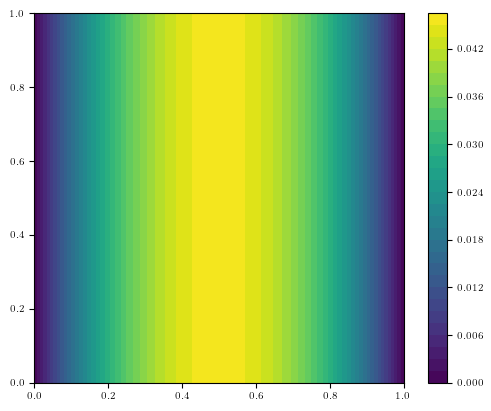

In [163]:
im = dl.plot(u)
plt.colorbar(im)

## 2. Building and solving the Bayesian inverse problem in CUQIpy <a class="anchor" id="Bayesian_problem"></a>
  
The goal is to infer the log conductivity profile $m(x)$ given observed data $d$. These observation can be of the potential directly, i.e. $d=u(x)$, or a function of the potential. 

The data $d$ is then given by:

$$ d = \mathcal{G}(m) + \eta$$


where 
- $\eta$ is the measurement noise
- $\mathcal{G}$ is the forward model operator which maps $m$ to the observations.


### 2.1. Create domain geometry 
We model $m$ as a Matern-class random field which lead to the parametrization (Karhunen-Lo\'eve (KL) expansion)
$$
    m(x) = \sum_{i\in \mathbb N} \sqrt{\lambda_i}\theta_i e_i(x)
$$
- $ \lambda_i $ and $ e_i $ are the eigenvalues and eigenvectors of the Matern covariance  operator
- $\theta_i\sim \mathcal N(0,1)$ are i.i.d. random variables.
- Now, $\theta_i$ are the Bayesian parameters

To define the Matern field (which represents the domain of our forward model) we use `cuqipy_fenics.geometry.MaternExpansion` and define the field as follows:

In [ ]:
# Define CUQI geometry on which m is defined
fenics_continuous_geo = cuqipy_fenics.geometry.FEniCSContinuous(parameter_function_space)

# Define the MaternExpansion geometry that maps the i.i.d random variables to Matern field realizations
domain_geometry = cuqipy_fenics.geometry.MaternExpansion(fenics_continuous_geo, length_scale = .1, num_terms=32)

We can look at realizations of the Matern class Gaussian random field 

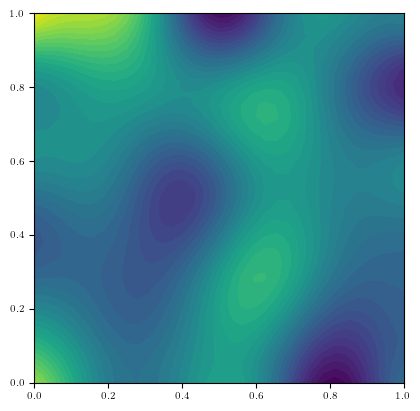

In [165]:
field_realization = domain_geometry.par2fun(np.random.randn(domain_geometry.par_dim))
dl.plot(field_realization)

### 2.2. Create range geometry

We create the range geometry which represents the forward model output (the solution $u$ in the entire domain in this case) 

In [166]:
range_geometry = cuqipy_fenics.geometry.FEniCSContinuous(solution_function_space)


### 2.3. Create cuqi forward model
Now we use `cuqi.model.PDEModel` which is an object that belongs to the CUQIpy library and is agnostic to the FEniCS code (FEniCS code is abstracted away in the `PDE` object and the geometries).

In [167]:
cuqi_model = cuqi.model.PDEModel(PDE, domain_geometry=domain_geometry, range_geometry=range_geometry)

### 2.4. Create prior

We create the prior distribution, which is a distribution of the expansion coefficients $\theta_i$

In [168]:
x = cuqi.distribution.Gaussian(np.zeros(cuqi_model.domain_dim), 1, geometry=domain_geometry)

We can plot prior samples

2

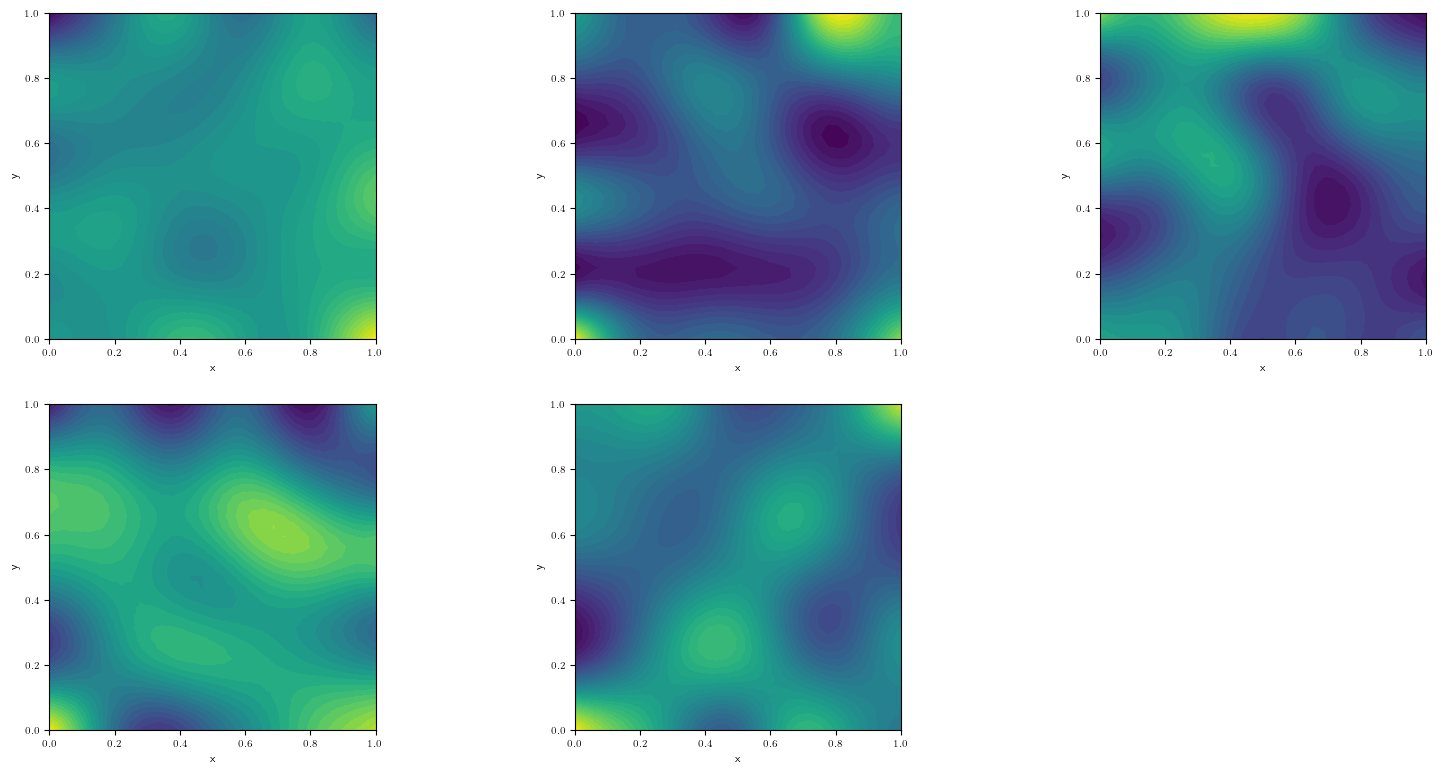

In [169]:
prior_samples = x.sample(5)
prior_samples.plot()
domain_geometry.physical_dim

### 2.5. Create exact solution and exact data

We create an exact solution (for simplification in this notebook, the exact solution is created from a prior sample, and furthermore, we do not pollute the data with noise):

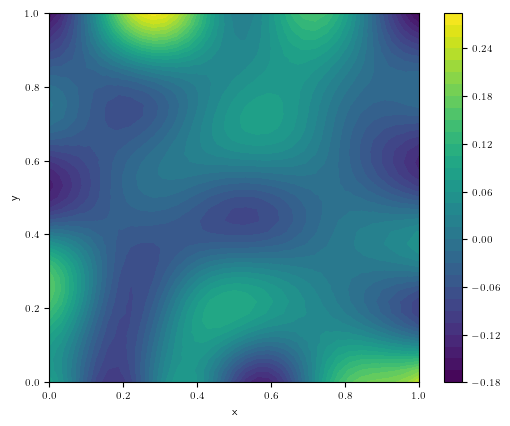

In [170]:
np.random.seed(15) #1
exact_solution =cuqi.array.CUQIarray(np.random.randn(domain_geometry.par_dim), is_par=True, geometry=domain_geometry)
#exact_solution_expr = dl.Expression("-0.24 + (0.18+0.24)*(    (pow(x[0]-0.5, 2)+  pow(x[1]-0.5, 2)) < pow(0.2,2) )", degree=2)
#exact_solusion_function = dl.Function(solution_function_space)
#exact_solusion_function.interpolate(exact_solution_expr)
#exact_solution = cuqi.array.CUQIarray(exact_solusion_function, is_par=False, geometry=range_geometry)

# plot exact solution
im = exact_solution.plot()
plt.colorbar(im[0])

Create synthesized data that corresponds to the exact_solution

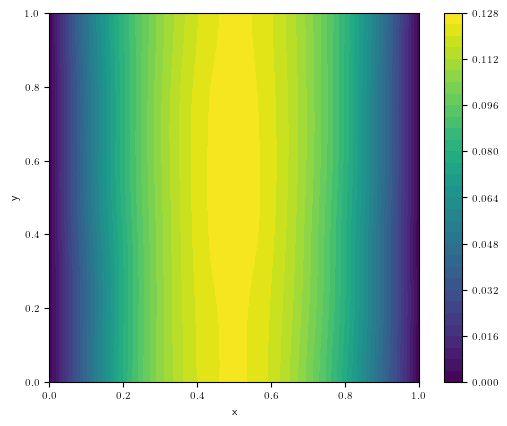

In [171]:
exact_data = cuqi_model(exact_solution)

# plot exact data
im = range_geometry.plot(exact_data)
plt.colorbar(im[0])

### 2.6. Create likelihood and data
We create the data distribution

In [172]:

noise = np.random.randn(len(exact_data))
noise_sd = .01*np.linalg.norm(exact_data)/np.linalg.norm(noise)
noise =  noise_sd*noise
#print(np.linalg.norm(noise)/np.linalg.norm(data))
data = exact_data + noise
print(np.linalg.norm(noise)/np.linalg.norm(data))
print(noise_sd)

y = cuqi.distribution.Gaussian(mean=cuqi_model(x), cov=noise_sd**2, geometry=range_geometry)

y

0.010000623917160755
0.0009038060382206346


CUQI Gaussian. Conditioning variables ['x'].

And we create the data (which we assume here is the `exact_data` to simplify the problem)

We plot the data

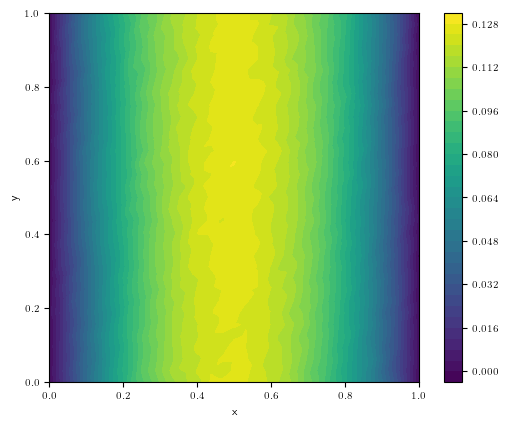

In [173]:
# plot data
im = range_geometry.plot(data)
plt.colorbar(im[0])

We create the likelihood function:

In [174]:
L = y(y=data)

### 2.7. Create the posterior

We create the posterior distribution

In [175]:
cuqi_posterior = cuqi.distribution.Posterior(L, x)

### 2.8. Sample the posterior
Create a pCN sampler

## 3. Using gradient-based sampler <a class="anchor" id="gradient_sampling"></a>

### 3.1. The chain rule

$$\nabla_\theta \mathrm{log}\rho_\mathrm{post}(\theta) \propto \nabla_\theta \mathrm{log}\rho_\mathrm{likelihood}(\mathcal{G}(m(\theta))) + \nabla_\theta \mathrm{log}\rho_\mathrm{prior}(\theta) $$

We have the maps:
- Domain geometry: $z := m(\theta)$
- Model: $y := \mathcal{G}(z) $


By the chain rule we have (for the likelihood part):

$$ \nabla_\theta \mathrm{log}\rho_\mathrm{likelihood}(\mathcal{G}(m(\theta))) = J_{m,\theta}^T(\theta) J_{\mathcal{G}, m}^T(m(\theta)) \nabla_y  \mathrm{log}\rho(\mathcal{G}(m(\theta))) $$ 

- We use adjoint-based method to compute $J_{\mathcal{G}, m}^T(m(\theta)) V$
	- Costs one forward solve and one adjoint solve (cheaper than finite difference approximation)


**This is done automatically by CUQIpy-FEniCS**

  

### 3.1 Set the adjoint problem boundary conditions

To compute the gradient using adjoint based method, we need to define the adjoint problem (which the `PDE` object infers) and derive the adjoint problem boundary conditions.

See: Gunzburger, M. D. (2002). Perspectives in flow control and optimization. Society for Industrial and Applied Mathematics, for adjoint based derivative derivation.

We create the adjoint problem boundary conditions and set it in the `PDE` object: 

In [176]:
adjoint_dirichlet_bc_expr = dl.Constant(0.0)
adjoint_dirichlet_bc = dl.DirichletBC(solution_function_space,
                                      adjoint_dirichlet_bc_expr,
                                      u_boundary) #adjoint problem bcs
PDE.adjoint_dirichlet_bc = adjoint_dirichlet_bc

### 3.2 Check the gradient correctness at a point $x_i$
We check the log posterior gradient correctness at a point $x_i$ by comparing the gradient CUQIpy-FEniCS computes using adjoint based method and the gradient computed using `scipy` `optimize.approx_fprime` method.

We first create a point $x_i$

In [177]:
# Create x_i
x_i = cuqi.array.CUQIarray(np.random.randn(domain_geometry.par_dim), is_par=True, geometry=domain_geometry)

Compute the posterior gradient using CUQIpy-FEniCS


In [178]:
print("Posterior gradient (cuqi.model)")
cuqi_grad = cuqi_posterior.gradient(x_i)


Posterior gradient (cuqi.model)


Compute the approximate gradient using `optimize.approx_fprime`


In [179]:
print("Scipy approx")
step = 1e-11   # finite diff step
scipy_grad = optimize.approx_fprime(x_i, cuqi_posterior.logpdf, step)

Scipy approx


Plot both gradients

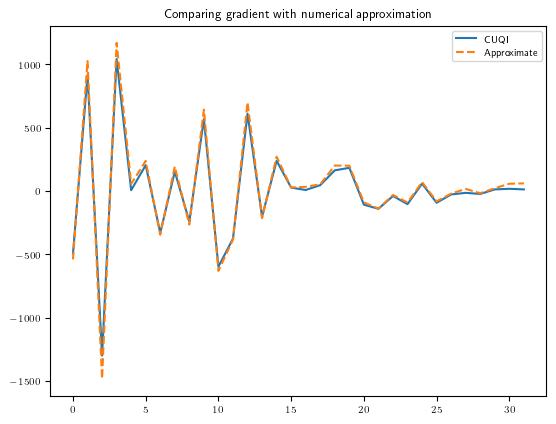

In [180]:
plt.plot(cuqi_grad, label='CUQI')
plt.plot(scipy_grad , '--', label='Approximate')
plt.legend()
plt.title("Comparing gradient with numerical approximation");

### 3.3. Use gradient based sampler (NUTS)

Create a gradient-based sampler (we use NUTS here)

In [181]:
Ns = 5000
sampler = cuqi.sampler.NUTS(cuqi_posterior)

Sample using NUTS (this may take a little while)

In [182]:
samples_NUTS = sampler.sample_adapt(Ns, Nb=10)

Sample 5010 / 5010


Plot the mean and the exact solution

Text(0.5, 1.0, 'Exact solution')

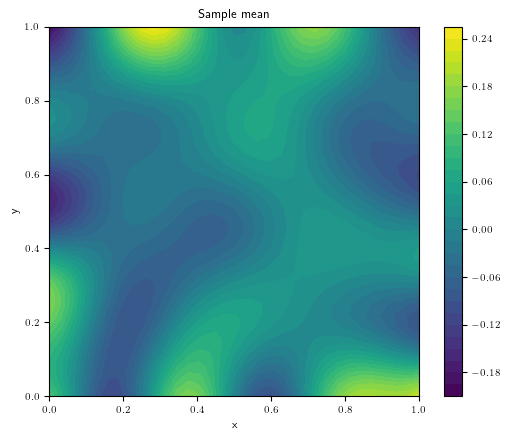

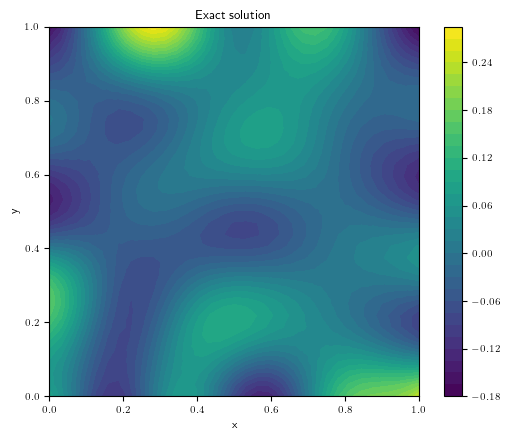

In [183]:
# plot samples mean
im = samples_NUTS.plot_mean()#(vmin=-1, vmax=2, mode='color')
cb = plt.colorbar(im[0])

# plot the exact solution
plt.figure()
im = exact_solution.plot()#(vmin=-1, vmax=2, mode='color')
cb = plt.colorbar(im[0])
plt.title('Exact solution')

Plot trace

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'v1'}>,
        <AxesSubplot: title={'center': 'v1'}>],
       [<AxesSubplot: title={'center': 'v2'}>,
        <AxesSubplot: title={'center': 'v2'}>],
       [<AxesSubplot: title={'center': 'v9'}>,
        <AxesSubplot: title={'center': 'v9'}>],
       [<AxesSubplot: title={'center': 'v13'}>,
        <AxesSubplot: title={'center': 'v13'}>],
       [<AxesSubplot: title={'center': 'v22'}>,
        <AxesSubplot: title={'center': 'v22'}>]], dtype=object)

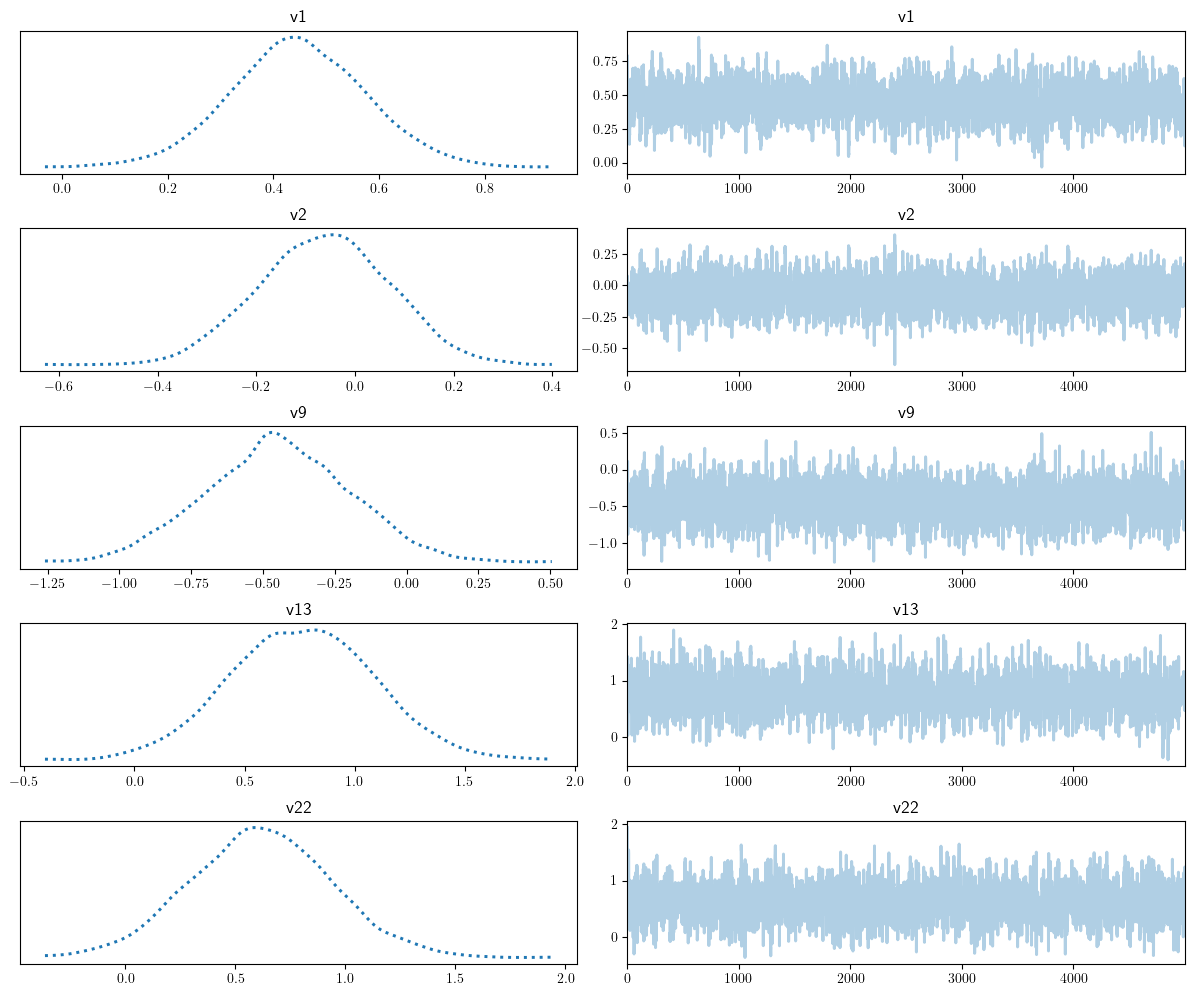

In [184]:
samples_NUTS.plot_trace()

We also plot the credibility interval

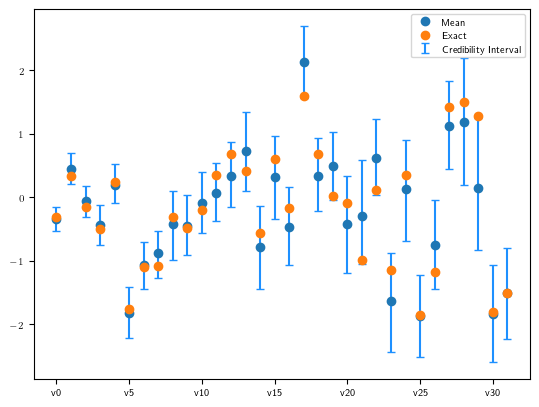

In [194]:
samples_NUTS.burnthin(4000).plot_ci(95,exact=exact_solution, plot_par=True)
plt.xticks(np.arange(x.dim)[::5],['v'+str(i) for i in range(x.dim)][::5]);

Now the sampling has gone better. This is because we utilized gradient information of the problem.

#### ★ Try yourself (optional):  

- What do you notice by comparing the trace plots of the pCN samples and the NUTS samples, and comparing the samples mean and the exact solution in both cases.
- Compute the effective samples size (ESS) for each case.
- In this example, we build FEniCS code PDE ourselves. CUQIpy-FEniCS also provides test problems. Copy-paste the code script you find on [CUQIpy-FEniCS main page](https://github.com/CUQI-DTU/CUQIpy-FEniCS) and run the code here. 


In [186]:
# Your code here

samples_NUTS.compute_ess()

array([1385.80023312, 1750.97116741, 2068.36473719, 1984.75345898,
       1782.63173242, 1227.52513317, 2011.86643042, 1960.13993153,
       2201.47876741, 1977.37180548, 1837.33626084, 2681.0431903 ,
       1596.99233998, 1492.90784526, 1645.57508881, 1233.19794953,
       1292.54692276, 1283.31800601, 1674.30168571, 1993.49850077,
       1045.6417754 , 1087.61580028, 1846.18122416, 1042.07633098,
        959.57521217, 2069.89607141, 1329.00509693, 1511.30584685,
        797.96651034,  803.78333259, 1462.36615527,  972.98124406])

In [215]:


dofs = np.empty((parameter_function_space.dim(), samples_NUTS.samples.shape[1]))
for i in range(samples_NUTS.samples.shape[1]):
    dofs[:, i] = domain_geometry.par2fun(samples_NUTS.samples[:,i]).vector().get_local() 



In [216]:
var_vec = np.var(dofs, axis=1)
var_fun = dl.Function(parameter_function_space)
var_fun.vector().set_local(var_vec)

In [225]:
error_vec = domain_geometry.par2fun( samples_NUTS.mean()).vector().get_local()- exact_solution.funvals.vector().get_local()
error_fun = dl.Function(parameter_function_space)
error_fun.vector().set_local(error_vec)

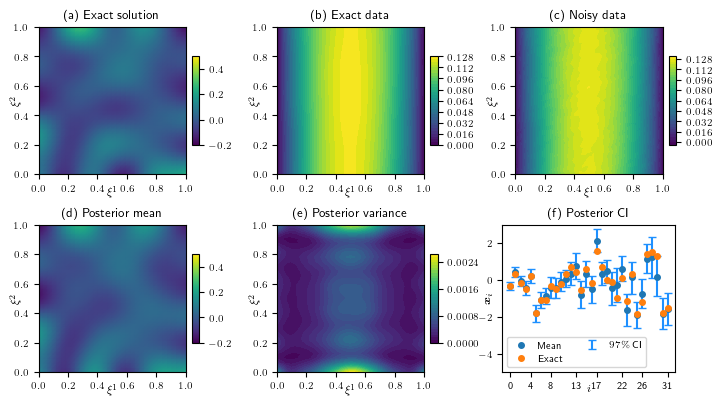

In [237]:
import os
from matplotlib import ticker
# %%
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# %%
# Data directory
fig_dir = './figs/'

n_burn = 0
# Figure file
fig_dir = fig_dir 
# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

version = 'v7'

fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'

# %% Create the figure
cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3,
                        figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                        layout="constrained")


## plot prior posterior samples and ESS
colors = ['C0', 'green', 'purple', 'k', 'gray']

# 1,1: exact solution
plt.sca(axs[0,0])

im = exact_solution.plot(subplots=False, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('(a) Exact solution')

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
#plt.annotate('(a)', xy=(0.03, 0.93), xycoords='axes fraction')

# 1,2: exact data
plt.sca(axs[0,1])

im = range_geometry.plot(exact_data, subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
#plt.colorbar(im[0])

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
#plt.annotate('(b)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.gca().set_title('(b) Exact data')

# 1,3: noisy data
plt.sca(axs[0,2])

im = range_geometry.plot(data, subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
#plt.annotate('(c)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.gca().set_title('(c) Noisy data')

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 2,1: mean
plt.sca(axs[1,0])

im = samples_NUTS.plot_mean(subplots=False, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)


plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
#plt.annotate('(d)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.gca().set_title('(d) Posterior mean')

# 2,2: variance
plt.sca(axs[1,1])

#im = samples_NUTS.plot_variance(subplots=False)
im = fenics_continuous_geo.plot(var_fun, is_par=False,subplots=False)
#im = fenics_continuous_geo.plot(error_fun, is_par=False,subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
cb.locator = ticker.MaxNLocator(nbins=4)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
#plt.annotate('(e)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.gca().set_title('(e) Posterior variance')

# 2,3: CI
plt.sca(axs[1,2])

lci = samples_NUTS.burnthin(n_burn).plot_ci(97, exact=exact_solution, plot_par=True, markersize=SMALL_SIZE-3)
lci[0].set_label("Mean")
lci[1].set_label("Exact")
lci[2].set_label("$97\\%$ CI")
plt.ylim(-5, 3)
plt.legend(ncols=2) #

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
plt.ylabel('$\\bm{x}_i$')
#plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.set_label_coords( -0.06, 0.5)
plt.xlabel('$i$')
plt.gca().xaxis.labelpad = -5#-3
#plt.gca().xaxis.set_label_coords(0.5, -0.14)
#plt.annotate('(f)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.gca().set_title('(f) Posterior CI')
n_ticks = 8
num_var = samples_NUTS.geometry.par_dim
tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
plt.xticks(tick_ids, tick_ids)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fig.tight_layout(pad=0, w_pad=0.1, h_pad=0.9)
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)





In [ ]:
np.savez(fig_dir+'fig_'+version+'.npz', samples_NUTS=samples_NUTS.samples, exact_solution=exact_solution.to_numpy(), exact_data=exact_data, data=data)

array([[<AxesSubplot: ylabel='v2'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='v1', ylabel='v10'>,
        <AxesSubplot: xlabel='v2'>]], dtype=object)

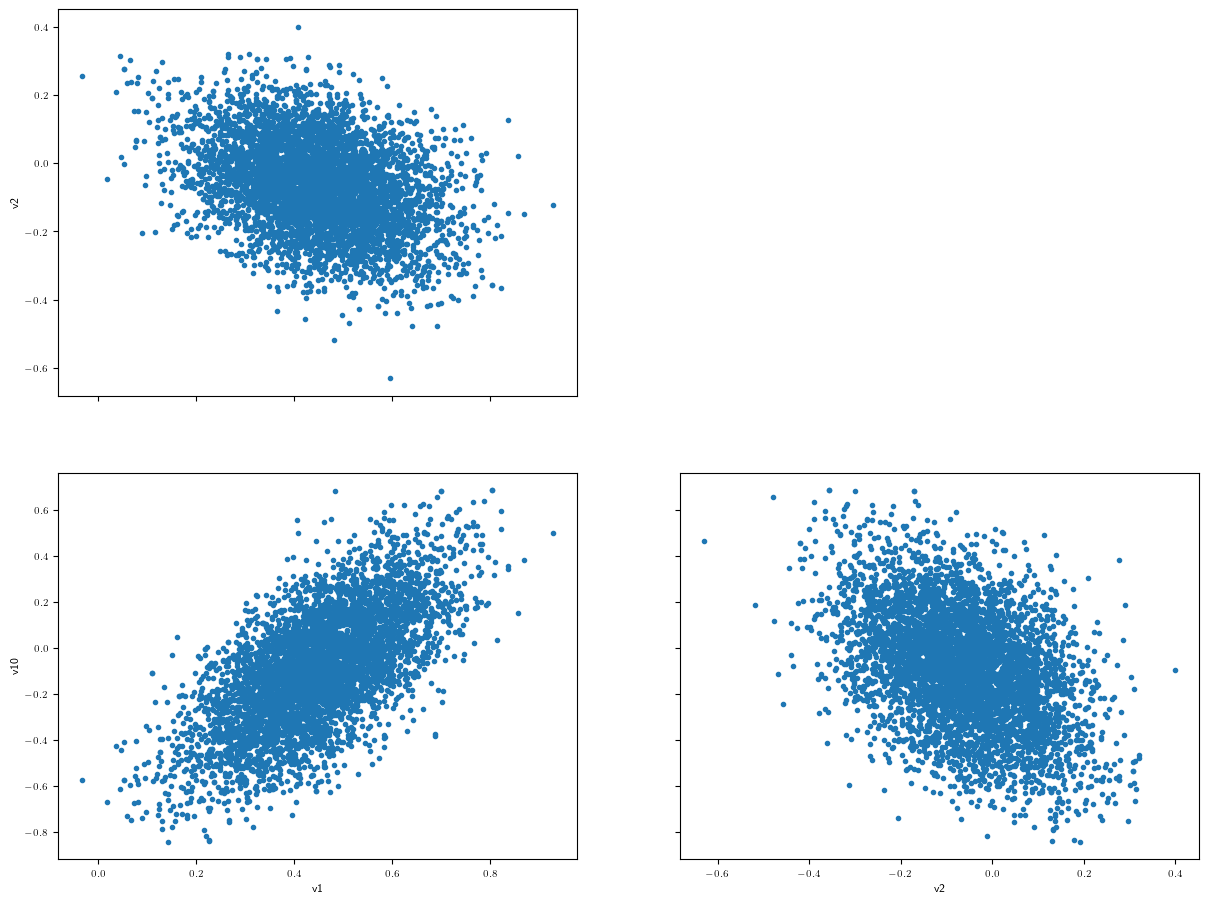

In [250]:
BP = cuqi.problem.BayesianProblem(y, x).set_data(y=data)
samples_NUTS.plot_pair([1,2, 10])